# Cdc2 Cyclin Model
Drew Willis

Source:</br>
Tyson, J. J. “Modeling the Cell Division Cycle: Cdc2 and Cyclin Interactions.” 
Proceedings of the National Academy of Sciences, vol. 88, no. 16, 1991, pp. 7328–7332., doi:10.1073/pnas.88.16.7328. https://www.pnas.org/content/pnas/88/16/7328.full.pdf


This is a recreation of Tyson's Cdc2 and Cyclin Interactions model, and includes extra tools to explore other aspects of the model.

In [1]:
import tellurium as te
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display, update_display

## Background
(still need description here, recommend reading the abstract (bold text) here: https://www.pnas.org/content/pnas/88/16/7328.full.pdf)

The cell cycle is composed of cell growth and mitosis. These processes have been shown to operate differently in relation to each other. We look at the cell cycle as two processes:
* Cell Growth cycle
* Cell Division cycle

The division cycle is determined by an enzyme, the maturation promoting factor (MPF). It is formed by cdc2 and cyclin in the cell and is autocatalytic. The MPF enzyme is necessary for mitotic processes to occur. Once the cell reaches anaphase, MPF is degraded and the cycle repeats.

MPF activation can depend on cell growth, cyclin levels in the cell, or other enzymes, depending on the cell type and environment.


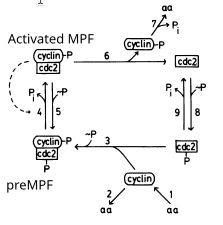
(Tyson)

In the model, this process is represented by 9 steps:
1. cyclin is created
2. cyclin can be unstable and be destroyed
3. cyclin is phosphorylated and forms heterodimer with 
4. cdc2-P to form preMPF
5. preMPF is dephosphorylated to form active MPF
6. MPF activation can be opposed
7. Nuclear is division triggered, and active MPF is destroyed, releasing phosphorylated cyclin
8. Phosphorylated cyclin is destroyed
9. cdc2 is phosphorylated
10. cdc2 can be reversed

The original paper uses a series of differential equations, but I have chosen to represent the model in arrow equation format that is functionally the same.
#### Model equations
1. C2 -> CP ; k8*P*C2
2. CP -> C2 ; k9*CP
3. CP -> pM ; k3*CP*Y
4. pM -> M ; pM * (k4p + k4*(M/CT)^2)
5. M -> pM ; k5*P*M
6. M -> C2 ; k6*M
7.   -> Y ; k1*aa
8. Y ->   ; k2*Y + k3*CP*Y
9.    -> YP ; k6*M
10. YP ->    ; k7*YP

(will clean up these equations with better formatting for readability)
##### Variable descriptions
* aa  : amino acids 
* C2  : cdc2
* CP  : cdc2-P
* pM  : P-cyclin-cdc2-P / preMPF
* M   : P-cyclin-cdc2   / active MPF
* Y   : cyclin
* CP  : cyclin-P
* CT  : total cdc2
* k4 > k4p

#### Expected Result
The conclusion of the original paper found three states in which the system would operate:

1. Steady state high MPF activity
2. Autonomous oscillations
3. Excitable steady state

## Cycle Model

In [2]:
# ----< DEFINE MODEL >----
model = '''
    // Equations
    E1: C2 -> CP ; k8*P*C2
    E2: CP -> C2 ; k9*CP
    E3: CP -> pM ; k3*CP*Y
    E4: pM -> M ; pM * (k4p + k4*(M/CT)^2)
    E5: M -> pM ; k5*P*M
    E6: M -> C2 ; k6*M
    E7:   -> Y ; k1*aa
    E8: Y ->   ; k2*Y + k3*CP*Y
    E9:    -> YP ; k6*M
    E10: YP ->    ; k7*YP
    
    
    CT := C2+CP+pM+M
    
    // Inputs
    k1 := 0.015*CT/aa
    k2 = 0
    k3 := 200/CT
    k4 = 100
    k4p = 0.018
    k5 = 0
    k6 = 0.5
    k7 = 0.6
    k8 = 100
    k9 = 10
    P = 1
    aa = 1
    
    C2 = 0.1
    CP = 1
    pM = 0.1
    M = 0.1
    Y = 0.1
    YP = 0.1
    

'''

    
# ----< WIDGETS >----

# model parameters
style = {'description_width': 'initial'}
k4_widget = widgets.FloatSlider(
    description='k4 rate constant',
    value=100.0,
    min=10.0,
    max=1000.0,
    continuous_update=False,
    style=style
)
k6_widget = widgets.FloatSlider(
    description='k6 rate constant',
    value=0.5,
    min=0.1,
    max=10.0,
    continuous_update=False,
    style=style
)

k8_widget = widgets.FloatSlider(
    description='k8 rate constant',
    value=0.5,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

k9_widget = widgets.FloatSlider(
    description='k9 rate constant',
    value=10.0,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

# simulation settings
sim_length_widget = widgets.IntSlider(
    description='simulation length',
    value=100,
    min=2,
    max=1000,
    continuous_update=False,
    style=style
)
sim_points_widget = widgets.IntSlider(
    description='simulated points',
    value=1000,
    min=2,
    max=20000,
    continuous_update=False,
    style=style
)


# display toggles
C2_widget = widgets.ToggleButton(
    description='C2 toggle',
    value=True,
)
CP_widget = widgets.ToggleButton(
    description='CP toggle',
    value=True,
)
pM_widget = widgets.ToggleButton(
    description='pM toggle',
    value=True,
)
Y_widget = widgets.ToggleButton(
    description='Y toggle',
    value=True,
)
M_widget = widgets.ToggleButton(
    description='M toggle',
    value=True,
)
YP_widget = widgets.ToggleButton(
    description='YP toggle',
    value=True,
)
yscale_widget = widgets.ToggleButton(
    description='yscale: linear',
    value=False
)

center_align = widgets.Layout(display='justify-content',
                flex_flow='column',
                align_items='stretch',
                width='100%')
right_align = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='flex-end',
                width='100%')
left_vbox = widgets.VBox([k4_widget,k6_widget,k8_widget,k9_widget])
right_vbox = widgets.VBox([sim_length_widget,sim_points_widget])
simulation_hbox = widgets.HBox([left_vbox,right_vbox],layout=center_align)
yscale_hbox = widgets.HBox([yscale_widget], layout=right_align)
display_toggles_hbox = widgets.HBox([C2_widget,CP_widget,pM_widget,Y_widget,M_widget,YP_widget])


# ----< PLOT SETUP >----

fig, axs = plt.subplots(1,figsize=(15,7))
plt.close()
fig2, axs2 = plt.subplots(1, figsize=(7,7))
axs.set(title='cdc2 cyclin model',xlabel='time',ylabel='variable')
axs2.set(title='pM vs YP',xlabel='pM',ylabel='YP')
plt.close()


# ----< INTERACT AND RUN >----

def RunModel(*args):
    # reload model in case user interacts with other cells and touches these widgets
    m = te.loada(model) 
    

    m.k4 = k4_widget.value
    m.k6 = k6_widget.value
    m.k8 = k8_widget.value
    m.k9 = k9_widget.value
    s = m.simulate(0,sim_length_widget.value,sim_points_widget.value,['time','C2','CP','pM','Y','M','YP'])
    
    axs.set(xlim=[0,sim_length_widget.value])
    linewidth = 2
    if C2_widget.value:
        axs.plot(s['time'],s['C2'],linewidth=linewidth,label='C2')
    if CP_widget.value:
        axs.plot(s['time'],s['CP'],linewidth=linewidth,label='CP')
    if pM_widget.value:
        axs.plot(s['time'],s['pM'],linewidth=linewidth,label='pM')
    if Y_widget.value:
        axs.plot(s['time'],s['Y'],linewidth=linewidth,label='Y')
    if M_widget.value:
        axs.plot(s['time'],s['M'],linewidth=linewidth,label='M')
    if YP_widget.value:
        axs.plot(s['time'],s['YP'],linewidth=linewidth,label='YP')
    if axs.lines:
        axs.legend(bbox_to_anchor=(0.1, -0.175, 0.8, .102), loc=2, ncol=3, mode="expand",fontsize='large')
    axs2.plot(s['pM'],s['YP'])
    update_display(display_id="0", obj=fig)
    update_display(display_id="1", obj=fig2)
    axs.cla()
    axs2.cla()
    axs.set(title='cdc2 cyclin model',xlabel='time',ylabel='variable')
    axs2.set(title='pM vs YP',xlabel='pM',ylabel='YP')

for i in range(len(left_vbox.children)):
    left_vbox.children[i].observe(RunModel,names='value')
for i in range(len(right_vbox.children)):
    right_vbox.children[i].observe(RunModel,names='value')
for i in range(len(display_toggles_hbox.children)):
    display_toggles_hbox.children[i].observe(RunModel,names='value')

RunModel()

## Model

Use the toggles to show and hide each component. The included rate constants have boundaries defined by the original paper. (Although k6 values should be rather low on the slider.)

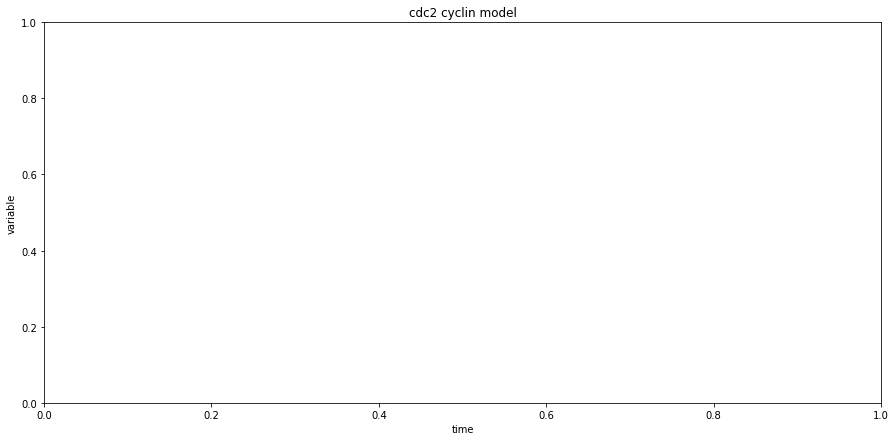

In [3]:
display(fig, display_id="0")
display(display_toggles_hbox)
display(simulation_hbox)
display(yscale_hbox)

## Simulation Energy
Reading this graph can tell you about the energy of the system and whether or not it will continue to oscillate.

I have chosen to graph YP against pM since their oscillations are always out of sync.
* Large loops in this graph indicate continuous oscillations.
* Loops decaying inwards indicate the steady state with high MPF activity.
* Loops that break outwards indicate the excitable switch with low MPF activity.

(still need a better way to describe this section)

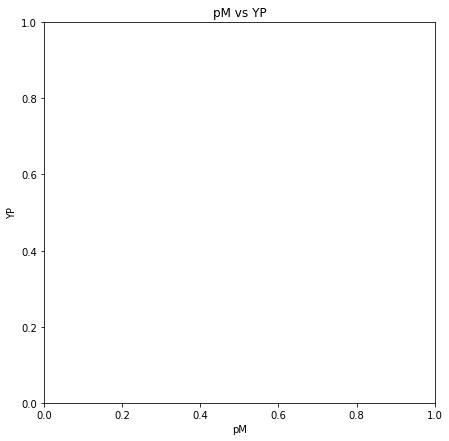

In [4]:
display(fig2, display_id="1")
display(display_toggles_hbox)
display(simulation_hbox)

### Parameter Scan

In [5]:
# ----< DEFINE MODEL >----
model = '''
    // Equations
    E1: C2 -> CP ; k8*P*C2
    E2: CP -> C2 ; k9*CP
    E3: CP -> pM ; k3*CP*Y
    E4: pM -> M ; pM * (k4p + k4*(M/CT)^2)
    E5: M -> pM ; k5*P*M
    E6: M -> C2 ; k6*M
    E7:   -> Y ; k1*aa
    E8: Y ->   ; k2*Y
    E9: Y ->   ; k3*CP*Y
    E10:    -> YP ; k6*M
    E11: YP ->    ; k7*YP
    
    
    CT := C2+CP+pM+M
    
    // Inputs
    k1 := 0.015*CT/aa
    k2 = 0
    k3 := 200/CT
    k4 = 100
    k4p = 0.018
    k5 = 0
    k6 = 0.5
    k7 = 0.6
    k8 = 100
    k9 = 10
    P = 1
    aa = 1
    
    C2 = 0.1
    CP = 1
    pM = 0.1
    M = 0.1
    Y = 0.1
    YP = 0.1
    

'''

    
# ----< WIDGETS >----

# model parameters
style = {'description_width': 'initial'}

k8_widget = widgets.FloatSlider(
    description='k8 rate constant',
    value=0.5,
    min=100.0,
    max=200.0,
    continuous_update=False,
    style=style
)

k9_widget = widgets.FloatSlider(
    description='k9 rate constant',
    value=10.0,
    min=10.0,
    max=200.0,
    continuous_update=False,
    style=style
)

# simulation settings
sim_length_widget = widgets.IntSlider(
    description='simulation length',
    value=250,
    min=2,
    max=1000,
    continuous_update=False,
    style=style
)
sim_points_widget = widgets.IntSlider(
    description='simulated points',
    value=500,
    min=2,
    max=20000,
    continuous_update=False,
    style=style
)


left_vbox = widgets.VBox([k8_widget,k9_widget])
right_vbox = widgets.VBox([sim_length_widget,sim_points_widget])
simulation_hbox = widgets.HBox([left_vbox,right_vbox])


# ----< PLOT SETUP >----

fig, axs = plt.subplots(1,figsize=(7,7))
axs.set(title='k4 vs k6 oscillation occurences',xlabel='k6',ylabel='k4')
plt.close()


# ----< INTERACT AND RUN >----
def GetState(s):
    oscillations=0
    flip=False
    highYP=0
    highpM=0
    for i in range(int(len(s)/2),len(s['pM'])):
        if flip:
            highYP+=1
            if s['pM'][i]>s['YP'][i]+0.075:
                oscillations += 1
                flip=False
        else:
            highpM+=1
            if s['pM'][i]<s['YP'][i]+0.075:
                oscillations += 1
                flip=True
    if oscillations>7:
        return "green"
    else:
        if highYP>highpM:
            return "red"
        else:
            return "orange"
    
            
        
    
def RunModel(*args):
    # reload model in case user interacts with other cells and touches these widgets
    m = te.loada(model) 
    x=[]
    y=[]
    color=[]
    for lk4 in np.arange(1.0,3.0,0.1):
        for lk6 in np.arange(-1.0,1.0,0.1):
            m.resetAll()
            m.k4 = 10**lk4
            m.k6 = 10**lk6
            m.k8 = k8_widget.value
            m.k9 = k9_widget.value
            s = m.simulate(0,sim_length_widget.value,sim_points_widget.value,['time','C2','CP','pM','Y','M','YP'])
            state = GetState(s)
            x.append(10**lk6)
            y.append(10**lk4)
            color.append(state)
    axs.scatter(x=x,y=y,color=color,label=color)
    axs.set(yscale='log',xscale='log')
    
    axs.legend(bbox_to_anchor=(0.1, -0.175, 0.8, .102), loc=2, ncol=3, mode="expand",fontsize='large')
    #axs.set(xlim=[0,10],ylim=[10,20])
    update_display(display_id="2", obj=fig)
    
    #axs.lines=[]
    axs.cla()
    axs.set(title='k4 vs k6 oscillation occurences',xlabel='k6',ylabel='k4')

for i in range(len(left_vbox.children)):
    left_vbox.children[i].observe(RunModel,names='value')
for i in range(len(right_vbox.children)):
    right_vbox.children[i].observe(RunModel,names='value')


## Parameter Scan
From the model and the paper we see that k4 and k6 are the most important factors that determine the fate of the simulation. We can do a parameter scan of k4 and k6 to see a 2-dimensional plot of the results

Sliders for k8 and k9 are included to observe whether or not they have a significant impact on the state of the simulation.

(The legend is currently broken)
* red : steady state, high MPF activity
* green : continuous oscillations
* yellow : excitable switch, low MPF activity

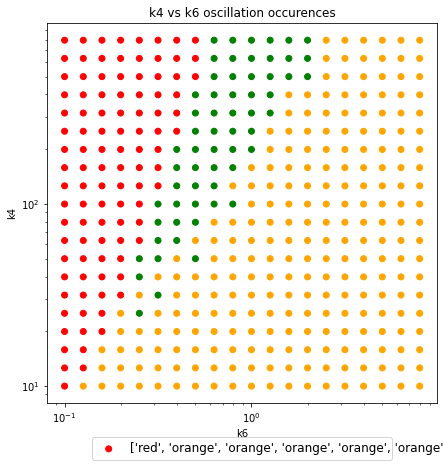

In [6]:
display(fig, display_id="2")
display(simulation_hbox)

We clearly see how low k6 and high k4 tends to the steady state and the reverse tends to the excitable switch. This result looks very similar to the results of fig. 2 in the original paper.

I believe this graph also definitively shows k8 and k9 have no effect on the simulation.

# Source
Tyson, J. J. “Modeling the Cell Division Cycle: Cdc2 and Cyclin Interactions.” Proceedings of the National Academy of Sciences, vol. 88, no. 16, 1991, pp. 7328–7332., doi:10.1073/pnas.88.16.7328.
https://www.pnas.org/content/pnas/88/16/7328.full.pdf